In [12]:
import argparse
import numpy as np
import os
import random
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import util
from models import Glow
from tqdm import tqdm
import matplotlib.pyplot as plt

In [13]:
device = 'cuda'

transform_test = transforms.Compose([
    transforms.ToTensor()
])
dataset = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform_test)

dataset.targets = torch.tensor(dataset.targets)

testloader = data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=8)
loss_fn = util.NLLLoss().to(device)
loss_meter = util.AverageMeter()


/home/yash/anaconda3/envs/glow/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [14]:

net = Glow(num_channels=64,num_levels=1,num_steps=8)
net = net.to(device)
net = torch.nn.DataParallel(net, [0])
# Load checkpoint.
print('Resuming from checkpoint at ckpts/best.pth.tar...')
assert os.path.isdir('ckpts'), 'Error: no checkpoint directory found!'
checkpoint = torch.load('ckpts/best.pth.tar')
net.load_state_dict(checkpoint['net'])
best_loss = checkpoint['test_loss']
start_epoch = checkpoint['epoch']


Resuming from checkpoint at ckpts/best.pth.tar...


In [15]:

@torch.no_grad()
def sample(net, batch_size, device):
    """Sample from RealNVP model.

    Args:
        net (torch.nn.DataParallel): The RealNVP model wrapped in DataParallel.
        batch_size (int): Number of samples to generate.
        device (torch.device): Device to use.
    """
    z = torch.randn((batch_size, 1, 28, 28), dtype=torch.float32, device=device)
    print(z.shape)
    x, _ = net(z, reverse=True)
    x = torch.sigmoid(x)

    return x


In [ ]:
z = torch.ones((1,1,28,28), dtype=torch.float32, device=device)
print(z.shape)
x, _ = net(z, reverse=True)
x = torch.sigmoid(x)
plt.imshow(x.cpu()[0].detach().numpy()[0,:,:])

torch.Size([10, 1, 28, 28])


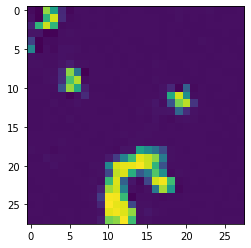

In [6]:
images = sample( net,10,'cuda')
plt.imshow(images.cpu()[1].numpy()[0,:,:])

In [7]:
images = []
print(images)
for i in range(10):
    images.append(dataset.data[dataset.targets == i ].to(device, dtype=torch.float32))
# dataset.targets= dataset.targets[idx]
# dataset.data = dataset.data[idx].to(device, dtype=torch.float32)

[]


In [8]:
print(images[9].shape)

torch.Size([1009, 28, 28])


In [9]:
x = images[2][:100]/255
x = torch.unsqueeze(x,1)
print(x.shape)
z , _ = net(x)

torch.Size([100, 1, 28, 28])


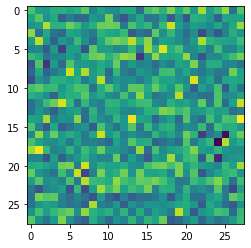

In [10]:
plt.imshow(z.cpu().detach()[80].numpy()[0,:,:])

In [11]:
x = images[9][:10]/255
x = torch.unsqueeze(x,1)
print(x.shape)
z , _ = net(x)

torch.Size([10, 1, 28, 28])


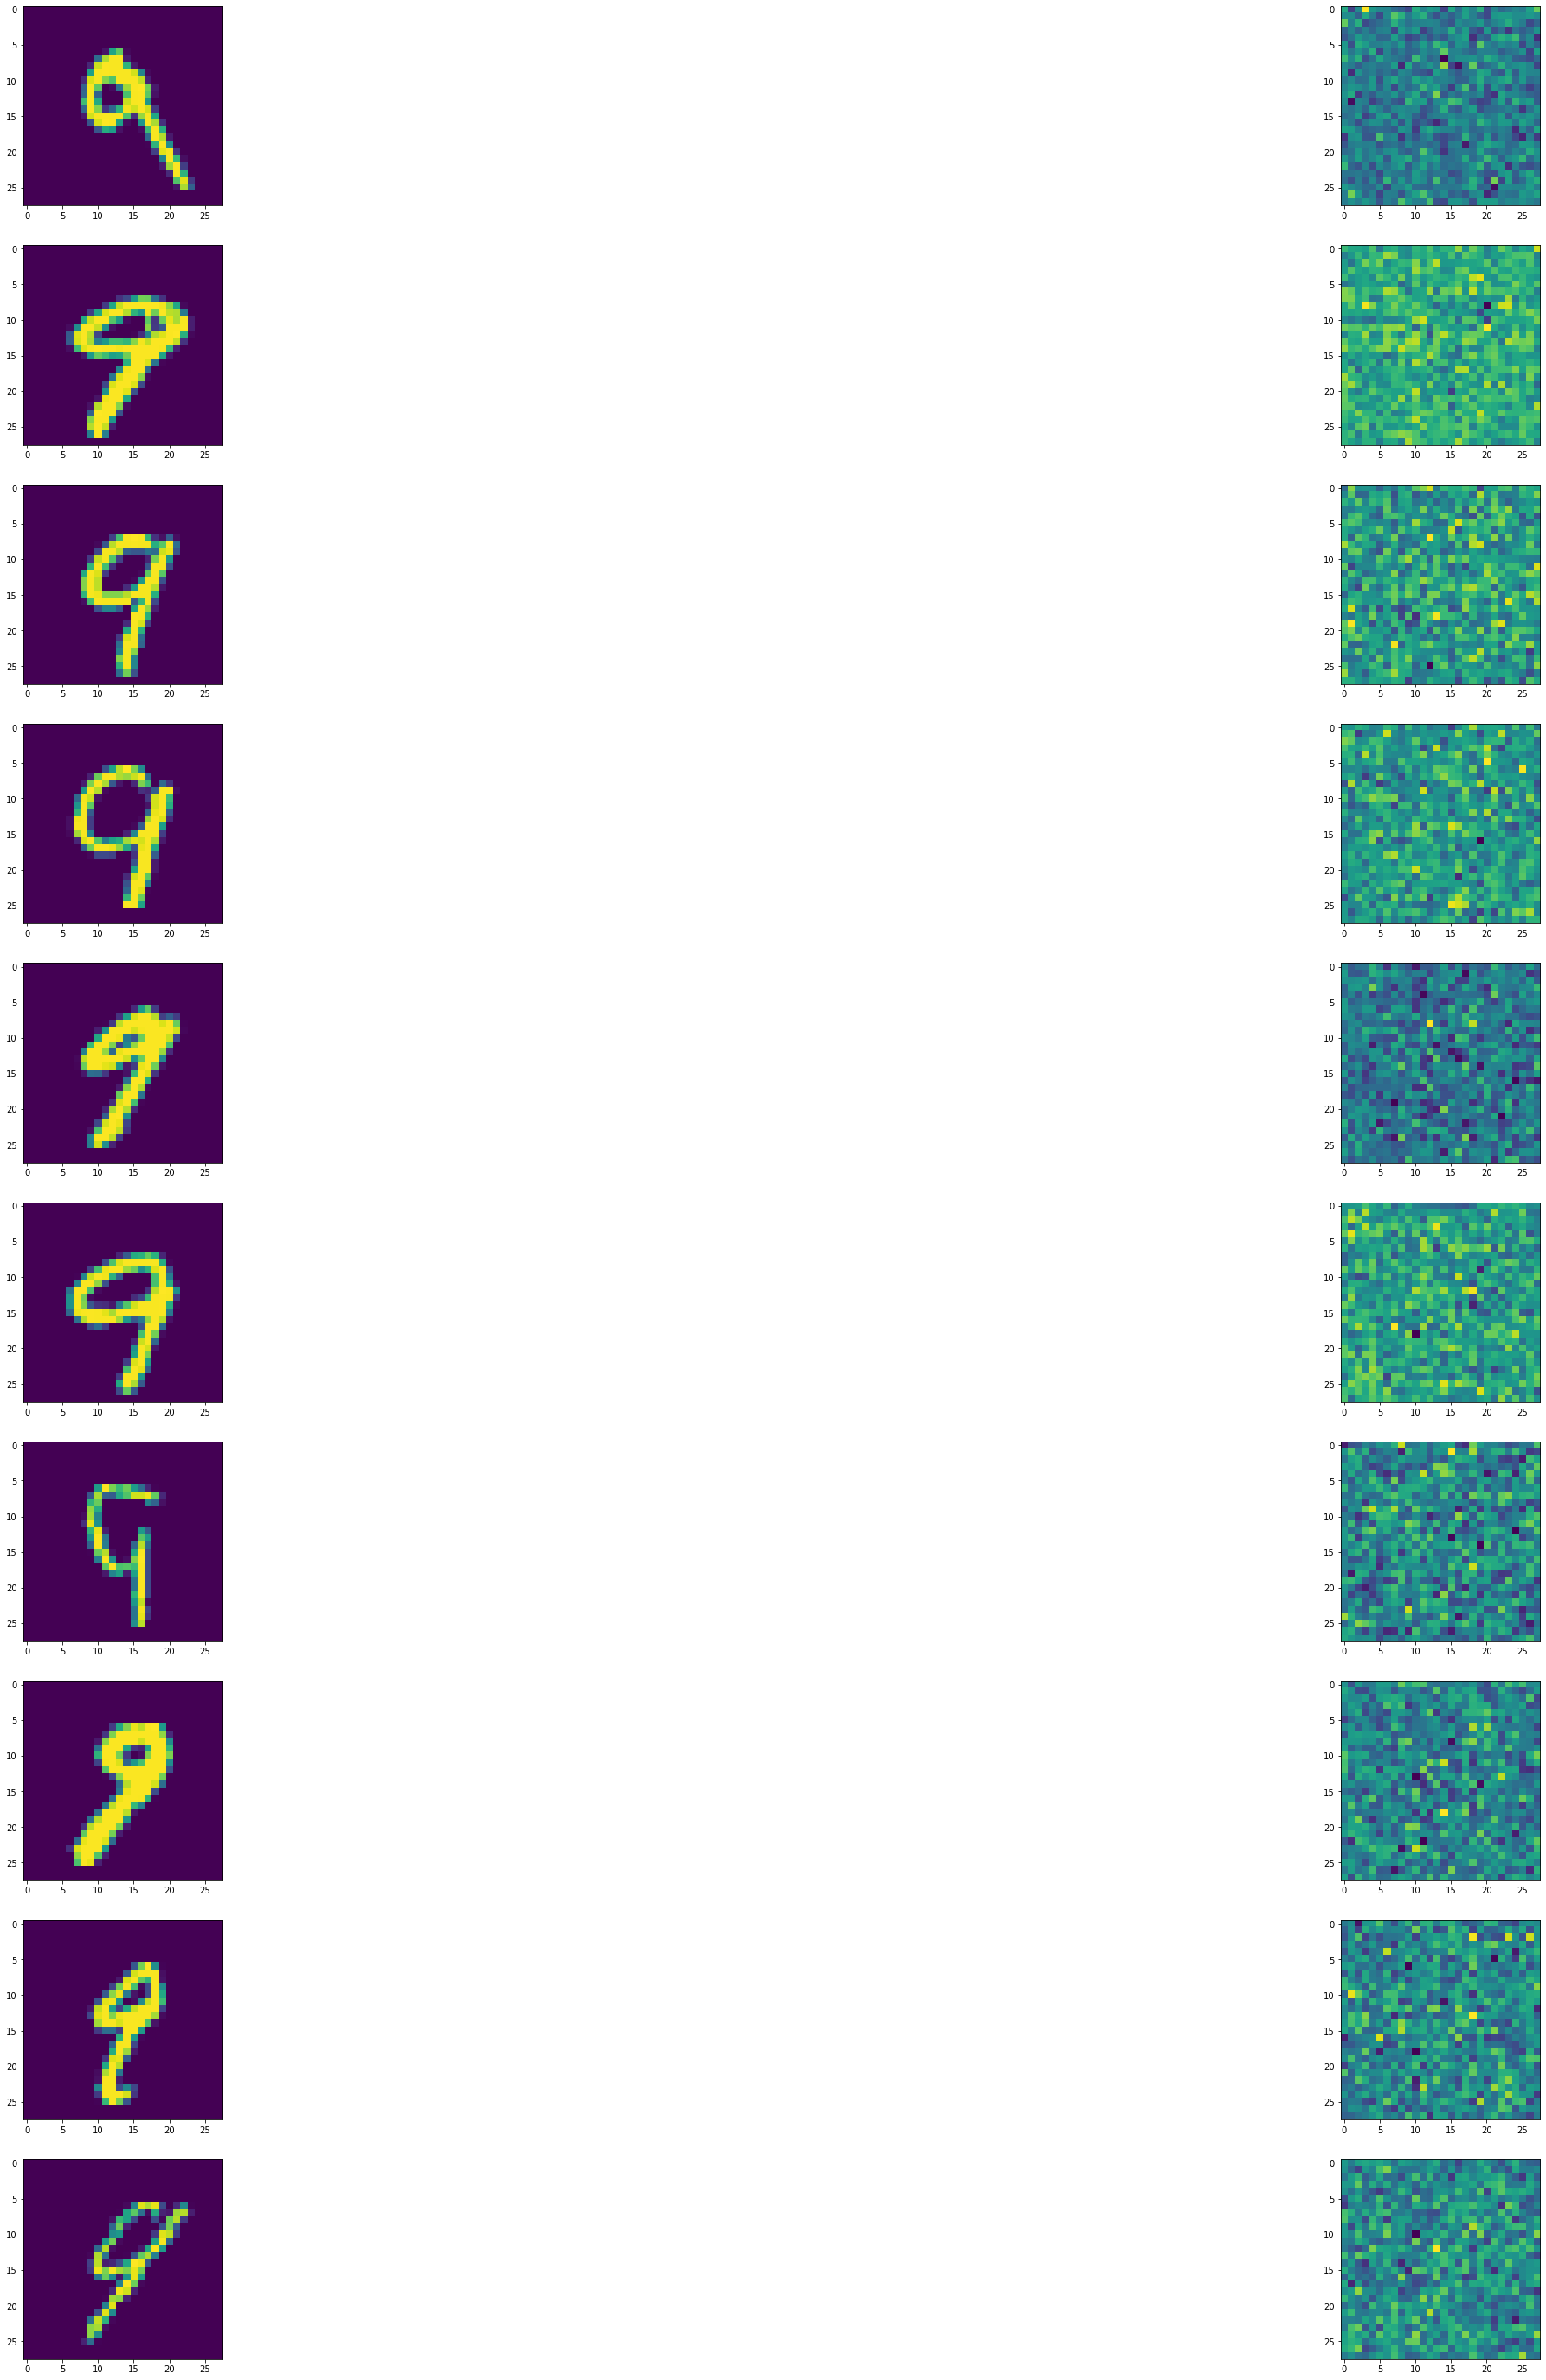

In [51]:

fig, axes= plt.subplots(nrows=10, ncols=2,figsize=(50,50))



for i in range(10):
#     plt.
#     plt.subplot(10,2,2*i+1)
    axes[i][0].imshow(images[9].cpu().detach()[i].numpy())
#     plt.subplot(10,2,2*i+2)
    axes[i][1].imshow(z.cpu().detach()[i].numpy()[0,:,:])


torch.Size([28, 28])


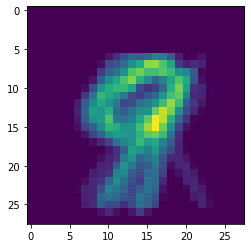

In [59]:
mean9 = torch.mean(images[9][:10],(0))
print(mean9.shape)
plt.imshow(z.cpu().detach()[1].numpy()[0,:,:])
plt.imshow(mean9.cpu().detach().numpy())
inp = mean9.unsqueeze(0).unsqueeze(0)
z , _ = net(inp/255)


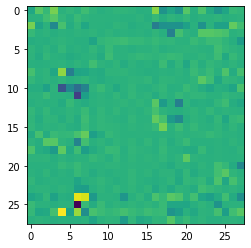

In [63]:
plt.imshow(z.cpu().detach()[0].numpy()[0,:,:])

In [66]:
z.max()

tensor(79.9969, device='cuda:0', grad_fn=<MaxBackward1>)

In [17]:

with tqdm(total=len(testloader.dataset)) as progress_bar:
    for x, _ in testloader:
        x = x.to(device)
        z, sldj = net(x, reverse=False)
        Zavg = z.mean(dim=0)
        loss = loss_fn(z, sldj)
        loss_meter.update(loss.item(), x.size(0))
        progress_bar.set_postfix(nll=loss_meter.avg,
                                 bpd=util.bits_per_dim(x, loss_meter.avg))
        progress_bar.update(x.size(0))


  1%|          | 64/10000 [00:00<01:13, 135.58it/s, bpd=1.11, nll=603]


RuntimeError: CUDA out of memory. Tried to allocate 12.25 MiB (GPU 0; 3.95 GiB total capacity; 2.30 GiB already allocated; 2.50 MiB free; 841.81 MiB cached)

In [ ]:
x =  dataset.data[:100]/255

In [ ]:
x.shape

In [ ]:
x = x.to(device)
z, sldj = net(x, reverse=False)